<a href="https://colab.research.google.com/github/prabhudc/covid-19/blob/master/air_quality_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !apt-get install libgeos
# !apt-get install libgeos-dev
# !pip install https://github.com/matplotlib/basemap/archive/master.zip

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.style as style
from mpl_toolkits.basemap import Basemap
style.available
style.use('seaborn-dark')

# Air-quality analysis

## Collect data

In [0]:
df_data_2020 = pd.read_csv('/content/drive/My Drive/DataScience/files/environment-article/waqi-covid19-airqualitydata-2020.csv',skiprows=[0,1,2,3])
df_data_2020 = df_data_2020[df_data_2020['Date'] >= '2020-03-01'].copy()
df_data_2019Q1 = pd.read_csv('/content/drive/My Drive/DataScience/files/environment-article/waqi-covid19-airqualitydata-2019Q1.csv',skiprows=[0,1,2,3])
df_data_2019Q2 = pd.read_csv('/content/drive/My Drive/DataScience/files/environment-article/waqi-covid19-airqualitydata-2019Q2.csv',skiprows=[0,1,2,3])
df_data_2019 = pd.concat([df_data_2019Q1[df_data_2019Q1['Date'] >= '2019-03-01'], df_data_2019Q2[df_data_ 2019Q2['Date'] <= '2019-04-25']])
del df_data_2019Q1
del df_data_2019Q2

In [0]:
df_data_2020.shape

(340679, 9)

In [0]:
df_data_2020.head()

,Date,Country,City,Specie,count,min,max,median,variance
1,2020-03-03,KG,Bishkek,wind speed,2,2.5,3.6,2.5,6.05
2,2020-03-18,KG,Bishkek,wind speed,24,0.5,4.6,3.0,13.30
3,2020-03-26,KG,Bishkek,wind speed,24,0.2,3.6,2.5,7.60
8,2020-03-04,KG,Bishkek,wind speed,5,0.5,2.5,2.0,8.25
10,2020-03-01,KG,Bishkek,wind speed,23,0.5,4.1,2.0,11.65


## Analysis pre-cleansing

### Analysis by country

In [0]:
df_data_2020['Country'].unique().shape

(95,)

In [0]:
df_data_2020['Country'].value_counts()

CN    64333
US    58500
JP    40379
FR    28786
KR    27387
      ...  
PR      451
CW      449
CI      288
GN      278
GH      180
Name: Country, Length: 95, dtype: int64

### Analysis by date

In [0]:
df_data_2020[(df_data_2020['City'] == 'Los Angeles') & (df_data_2020['Date'] == '2020-04-18') ]

,Date,Country,City,Specie,count,min,max,median,variance
200266,2020-04-18,US,Los Angeles,humidity,72,48.0,87.8,71.3,985.10
200397,2020-04-18,US,Los Angeles,pressure,72,1015.7,1018.9,1017.2,6.93
200443,2020-04-18,US,Los Angeles,wind-speed,60,0.1,7.0,3.0,31.21
200484,2020-04-18,US,Los Angeles,no2,45,1.9,11.2,5.6,62.77
200598,2020-04-18,US,Los Angeles,pm25,16,13.0,30.0,21.0,289.62
200745,2020-04-18,US,Los Angeles,temperature,72,13.1,18.3,15.0,25.12
200964,2020-04-18,US,Los Angeles,dew,20,7.0,11.0,9.0,17.32
201035,2020-04-18,US,Los Angeles,pm10,22,9.0,17.0,11.0,53.96
201093,2020-04-18,US,Los Angeles,o3,24,15.2,29.6,24.1,167.90
201209,2020-04-18,US,Los Angeles,wind-gust,31,0.2,10.6,4.3,129.02


### Analysis by metric

In [0]:
df_data_2020['Specie'].value_counts()

temperature      33419
humidity         33406
pressure         33309
pm25             28389
pm10             27472
no2              27406
dew              26097
o3               25567
so2              22870
co               21024
wind speed       18097
wind-speed       16106
wind gust        11291
wind-gust         8865
precipitation     3066
wd                2477
aqi                754
uvi                545
pm1                221
pol                130
neph               112
mepaqi              56
Name: Specie, dtype: int64

## Prepare Data

We decide to use the PM2.5 as the metric of choice and daily-median values as the measurement criteria. Let filter the dataset and restrict to the relavent columns

In [0]:
df_data_2020_pm25 = df_data_2020[df_data_2020['Specie'] == 'pm25'][['Date','Country','City','median']]
df_data_2019_pm25 = df_data_2019[df_data_2019['Specie'] == 'pm25'][['Date','Country','City','median']]

Now to combine both the dataset for ease of analysis

In [0]:
# Conver the date fields to date-type
df_data_2020_pm25['Date'] = pd.to_datetime(df_data_2020_pm25['Date'])
df_data_2019_pm25['Date'] = pd.to_datetime(df_data_2019_pm25['Date'])

# Create a new day-month field for joining data across years
df_data_2020_pm25['month_day'] = df_data_2020_pm25['Date'].apply( lambda x : str(x.month).zfill(2) + '-' + str(x.day).zfill(2) )
df_data_2019_pm25['month_day'] = df_data_2019_pm25['Date'].apply( lambda x : str(x.month).zfill(2) + '-' + str(x.day).zfill(2) )

# Drop the Date fields
df_data_2020_pm25.drop(['Date'],axis=1,inplace=True)
df_data_2019_pm25.drop(['Date'],axis=1,inplace=True)

# Drop data where median values are not known
df_data_2020_pm25 = df_data_2020_pm25[df_data_2020_pm25['median'] != 0].copy()
df_data_2019_pm25 = df_data_2019_pm25[df_data_2019_pm25['median'] != 0].copy()

Now to combine data from both the years into a single set

In [0]:
pm25_columns = ['month_day','Country','City','median_2019','median_2020']
df_pm25 = df_data_2019_pm25.merge(df_data_2020_pm25,on=['month_day','Country','City'],how='inner',suffixes=['_2019','_2020'])[pm25_columns].copy()

In [0]:
df_pm25.head()

,month_day,City,median_2019,median_2020
19,03-02,Abu Dhabi,68.0,93.0
9,03-03,Abu Dhabi,78.0,30.0
24,03-04,Abu Dhabi,76.0,25.0
28,03-05,Abu Dhabi,82.0,59.0
14,03-06,Abu Dhabi,104.0,70.0


Not all cities would have data for all days, Lets determine cities that have sparse data and drop. 

In [0]:
df_pm25['City'].value_counts() 

London          110
Bergen           56
Shijiazhuang     56
Turku            56
Ürümqi           56
               ... 
Richmond         14
Reading          14
San Juan          5
Bloemfontein      1
Algiers           1
Name: City, Length: 455, dtype: int64

We will set 52 as the lower-threshold. Cities which do not have have PM25 readings for over 52 days from January-1st until April-25th will be ignored.

In [0]:
days_threshold = 52
city_day_count = df_pm25['City'].value_counts()
cities_over_threshold_days = city_day_count[city_day_count.values >= days_threshold]

print(cities_over_threshold_days.index)
print("Number of cities : {}".format(len(cities_over_threshold_days)))

Index(['London', 'Xuchang', 'Houston', 'Helsinki', 'Grenoble', 'Ürümqi',
       'Lyon', 'Malmö', 'Rijeka', 'Vienna',
       ...
       'Tallinn', 'Niš', 'Milan', 'Muzaffarnagar', 'Visakhapatnam', 'Turin',
       'Brescia', 'Aguascalientes', 'Oaxaca', 'San Salvador'],
      dtype='object', length=384)
Number of cities : 384


Restrict the data to these cities

In [0]:
 df_pm25 = df_pm25.merge(pd.Series(cities_over_threshold_days.index,name='City'),how='inner').copy()

## Analysis

To be able to highlight the variation across, we would want focus on a few cities. To determine which cities could be the ideal candidates, lets find the difference for each city across years

For each city, we subtract the median values of 2019 from 2020, sum them up and devide by the number of readings in a year in 2019 and 2020.

In [0]:
df_pm25['comparative_median'] = df_pm25['median_2019'] - df_pm25['median_2020']

In [0]:
# Sum up the differences between years
df_pm25_city_comparison = df_pm25[['City','comparative_median']].groupby('City').sum().reset_index()
# Get the count of readings known per city
df_pm25_city_comparison['reading_count'] = pd.Series(df_pm25['City'].value_counts().sort_index().values)
# Devide to get an average measurement
df_pm25_city_comparison['change'] = round(df_pm25_city_comparison['comparative_median'] / df_pm25_city_comparison['reading_count'],2)

Lookup the contries

In [0]:
df_pm25_city_comparison = df_pm25[['City','Country']].groupby(by=['City','Country']).count().reset_index().merge(df_pm25_city_comparison ).copy()

In [0]:
df_pm25_city_comparison.sort_values(by=['change'], ascending=False).head(40)

,City,Country,comparative_median,reading_count,change
95,Gandhinagar,IN,3088.0,54,57.19
203,Muzaffarnagar,IN,2203.0,52,42.37
75,Delhi,IN,2066.0,55,37.56
0,Abu Dhabi,AE,2026.0,54,37.52
98,Ghāziābād,IN,2046.0,55,37.20
348,Ulan Bator,MN,1983.0,56,35.41
176,Lucknow,IN,1911.0,55,34.75
210,Nanjing,CN,1892.0,56,33.79
24,Bhopal,IN,1814.0,55,32.98
27,Bishkek,KG,1796.0,55,32.65


## Visualize

In [0]:
def prepare_dataset(df_pm25,city):
  # sort for easy visualization
  df_pm25 = df_pm25.sort_values(by=['City','month_day'])[['month_day','City','median_2019','median_2020']].copy()
  # combine the columns for seperate years into a single column
  df_chart_data_1 =  df_pm25[df_pm25['City'] == city][['City','month_day','median_2019']].copy()
  df_chart_data_1['year'] = 2019
  df_chart_data_1.rename({'median_2019':'median'},inplace=True,axis=1)
  df_chart_data_2 =  df_pm25[df_pm25['City'] == city][['City','month_day','median_2020']].rename({'median_2020':'median'}).copy()
  df_chart_data_2['year'] = 2020
  df_chart_data_2.rename({'median_2020':'median'},inplace=True,axis=1)
  df_chart_data = pd.concat([df_chart_data_1, df_chart_data_2])
  return df_chart_data

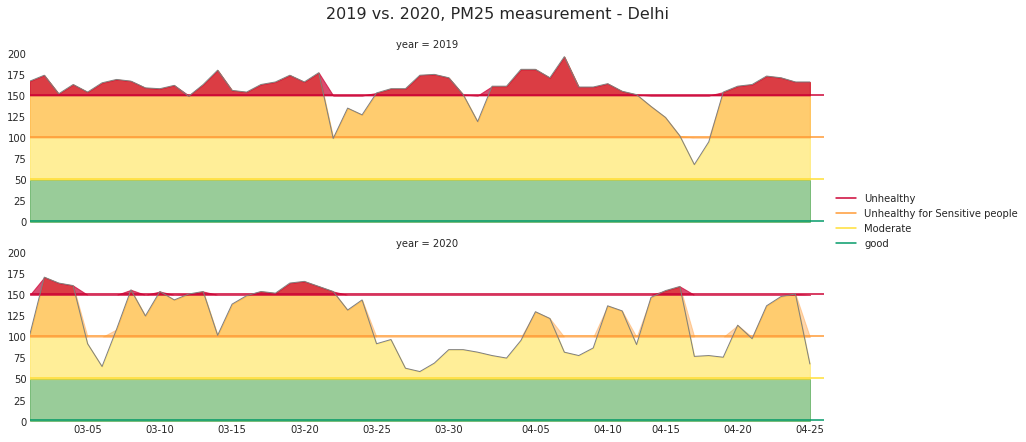

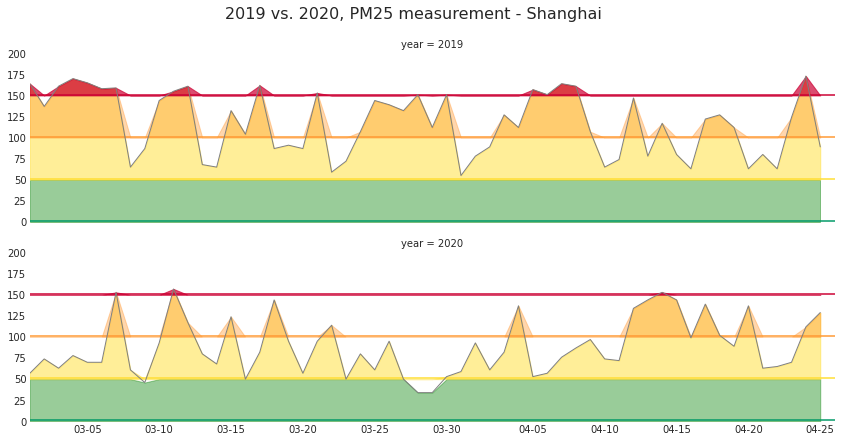

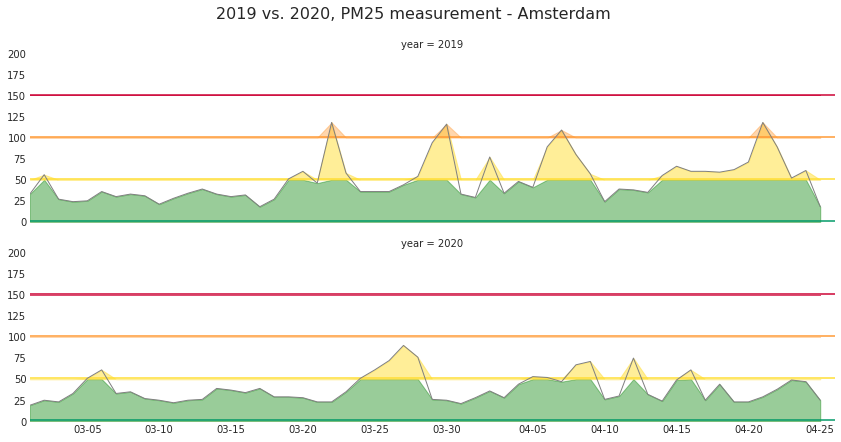

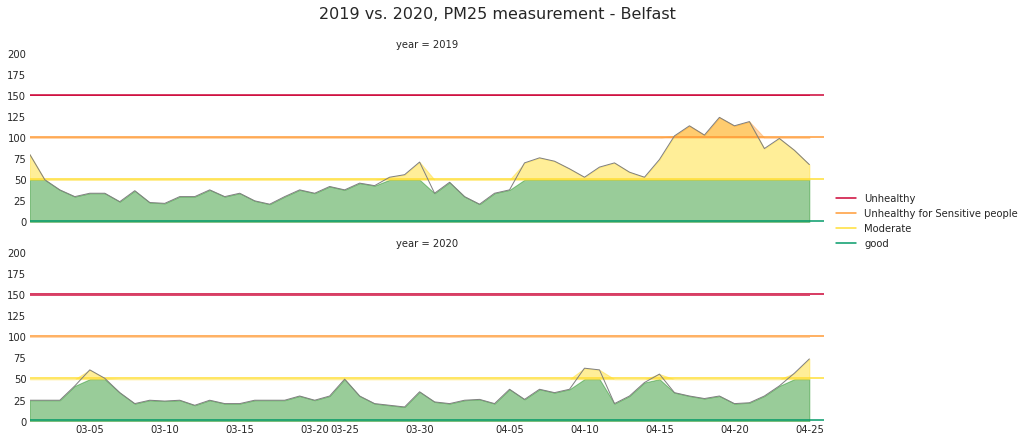

In [0]:
sns.set_style("white")
cities_to_analyze = ['Delhi','Shanghai','Amsterdam','Belfast']
unhealthy_threshold = 150.0
unhealthy_sensitive_threshold = 100.0
moderate_threshold = 50.0
good_threshold = 0.0
df_chart_data = pd.DataFrame()
print("")
for city in  cities_to_analyze:
  df_chart_data = prepare_dataset(df_pm25 , city)

  # Create a threshold for filling the chart for unhealthy readings
  df_chart_data["unhealthy_thresh"] = unhealthy_threshold
  df_chart_data["unhealthy_val"] = df_chart_data["median"].apply(lambda x : x if x > unhealthy_threshold else unhealthy_threshold)
  # Create a threshold for filling the chart for unhealthy for senitive - readings
  df_chart_data["unhealthy_sensitive_thresh"] = unhealthy_sensitive_threshold
  df_chart_data["unhealthy_sensitive_val"] = df_chart_data["median"].apply(lambda x : x if (x > unhealthy_sensitive_threshold)  else unhealthy_sensitive_threshold)
  # Create a threshold for filling the chart for moderately impactful readings
  df_chart_data["moderate_threshold"] = moderate_threshold
  df_chart_data["moderate_threshold_val"] = df_chart_data["median"].apply(lambda x : x if x > moderate_threshold else moderate_threshold)
  # Create a threshold for filling the chart for good pm25 values
  df_chart_data["good_threshold"] = good_threshold
  df_chart_data["good_threshold_val"] = df_chart_data["median"].apply(lambda x : x if x > good_threshold else good_threshold)
  df_chart_data["good_threshold_val"] = df_chart_data["good_threshold_val"].apply(lambda x : x if x < moderate_threshold else moderate_threshold)

  g = sns.FacetGrid(row="year", data=df_chart_data,aspect=4,legend_out=True)
  g.fig.suptitle('2019 vs. 2020, PM25 measurement - ' + city, y=1.05,x=.5,fontsize=16)
  # Draw the threshold lines
  g.map(plt.axhline,y=151,color="#cc0033",lw=1.5,label="Unhealthy")
  g.map(plt.axhline,y=101,color= "#ff9933",lw=1.5,label="Unhealthy for Sensitive people")
  g.map(plt.axhline,y=51,color= "#ffde33",lw=1.5,label="Moderate")
  g.map(plt.axhline,y=1,color= "#009966",lw=1.5,label="good")
  (g.map(sns.lineplot, "month_day","median",color="gray",lw=1))
  g.set(xticks=['03-05','03-10','03-15','03-20','03-25','03-30','04-05','04-10','04-15','04-20','04-25'])  
  g.set(xlim=('03-01','04,25'))
  g.set(ylim=(0,200))
  g.map(plt.fill_between,"month_day","good_threshold_val","good_threshold", color="green",alpha=0.4)
  g.map(plt.fill_between,"month_day","moderate_threshold_val","moderate_threshold", color="#ffde33",alpha=0.5)
  g.map(plt.fill_between,"month_day","unhealthy_sensitive_val","unhealthy_sensitive_thresh", color="#ff9933",alpha=0.4)
  g.map(plt.fill_between,"month_day","unhealthy_val","unhealthy_thresh", color="#cc0033",alpha=0.7)
  
  g.fig.frameon = True
  g.set_ylabels('pm25')
  g.set_ylabels("")
  g.set_xlabels("")
  
  if (city == cities_to_analyze[0]) or (city == cities_to_analyze[len(cities_to_analyze)-1]):
    g.add_legend()
  plt.show()


# Air traffic analysis

In this section of the analysis, we compare the air traffic on a day in January with a day in March. Considering that the volume of data is quite large, I chose to focus on a restricted number of airport to be able to highlight the difference.

## Collect data

In [0]:
df_opensky_jan_2020 = pd.read_csv('/content/drive/My Drive/DataScience/files/environment-article/flightlist_20200101_20200131.csv')
df_opensky_jan_2020['FL_DATE'] = pd.to_datetime(df_opensky_jan_2020['day']).apply(lambda x : x.date())
df_opensky_feb_2020 = pd.read_csv('/content/drive/My Drive/DataScience/files/environment-article/flightlist_20200201_20200229.csv')
df_opensky_feb_2020['FL_DATE'] = pd.to_datetime(df_opensky_feb_2020['day']).apply(lambda x : x.date())
df_opensky_mar_2020 = pd.read_csv('/content/drive/My Drive/DataScience/files/environment-article/flightlist_20200301_20200331.csv')
df_opensky_mar_2020['FL_DATE'] = pd.to_datetime(df_opensky_mar_2020['day']).apply(lambda x : x.date())


In [0]:
df_airports = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat',header=None)
df_airports.columns = ['Airport ID','Name','City','Country','IATA','ICAO','Latitude','Longitude','Altitude','Timezone','DST','Tz database time zone','Type','Source']

## Cleaning


In [0]:
# Lets drop the records which have origin or destination not known
df_jan_orig_dest_day =  df_opensky_jan_2020[~(df_opensky_jan_2020['origin'].isna() | df_opensky_jan_2020['destination'].isna()) ][['FL_DATE','origin','destination']]
df_feb_orig_dest_day =  df_opensky_feb_2020[~(df_opensky_feb_2020['origin'].isna() | df_opensky_feb_2020['destination'].isna()) ][['FL_DATE','origin','destination']]
df_mar_orig_dest_day =  df_opensky_mar_2020[~(df_opensky_mar_2020['origin'].isna() | df_opensky_mar_2020['destination'].isna()) ][['FL_DATE','origin','destination']]


Lets remove duplicates. Now, there could be rare cases where there are flights from the same source to the same destination within a day, but we are going to ignore those cases

In [0]:
df_jan_orig_dest_day.drop_duplicates(inplace=True)
df_feb_orig_dest_day.drop_duplicates(inplace=True)
df_mar_orig_dest_day.drop_duplicates(inplace=True)

We are attempting compare the 

Group by on each origin airport and collect the counts

In [0]:
# Get count by origin for the month of January
df_count_origin_jan = df_jan_orig_dest_day[['origin','FL_DATE']].groupby(by=['origin','FL_DATE']).size().reset_index()
df_count_origin_jan.columns = ['origin','FL_DATE','count']

# Get count by origin for the month of February
df_count_origin_feb = df_feb_orig_dest_day[['origin','FL_DATE']].groupby(by=['origin','FL_DATE']).size().reset_index()
df_count_origin_feb.columns = ['origin','FL_DATE','count']

# Get count by origin for the month of March
df_count_origin_mar = df_mar_orig_dest_day[['origin','FL_DATE']].groupby(by=['origin','FL_DATE']).size().reset_index()
df_count_origin_mar.columns = ['origin','FL_DATE','count']

Group by on each destination airport and collect the counts

In [0]:
# Get count by destination for the month of January
df_count_dest_jan = df_jan_orig_dest_day[['destination','FL_DATE']].groupby(by=['destination','FL_DATE']).size().reset_index()
df_count_dest_jan.columns = ['destination','FL_DATE','count']

# Get count by destination for the month of February
df_count_dest_feb = df_feb_orig_dest_day[['destination','FL_DATE']].groupby(by=['destination','FL_DATE']).size().reset_index()
df_count_dest_feb.columns = ['destination','FL_DATE','count']

# Get count by destination for the month of March
df_count_dest_mar = df_mar_orig_dest_day[['destination','FL_DATE']].groupby(by=['destination','FL_DATE']).size().reset_index()
df_count_dest_mar.columns = ['destination','FL_DATE','count']

Now combine the count of flights inbound towards the airport and outbound from the airport to arrive at a total count signifying how busy the airport was.

In [0]:
# Combine counts for the of January
df_count_jan = df_count_origin_jan.merge(df_count_dest_jan,left_on=['origin','FL_DATE'],right_on=['destination','FL_DATE'],how='inner')
# Combine counts for the of February
df_count_feb = df_count_origin_feb.merge(df_count_dest_feb,left_on=['origin','FL_DATE'],right_on=['destination','FL_DATE'],how='inner')
# Combine counts for the of March
df_count_mar = df_count_origin_mar.merge(df_count_dest_mar,left_on=['origin','FL_DATE'],right_on=['destination','FL_DATE'],how='inner')

Sum up the counts to determine how busy an aiport was each day

In [0]:

df_count_jan['TOTAL_COUNT'] = df_count_jan['count_x'] + df_count_jan['count_y']
df_count_feb['TOTAL_COUNT'] = df_count_feb['count_x'] + df_count_feb['count_y']
df_count_mar['TOTAL_COUNT'] = df_count_mar['count_x'] + df_count_mar['count_y']

Lets try to find top 5 busiest aiports jn January

In [0]:
df_count_jan_all_days = df_count_jan[['origin','TOTAL_COUNT']].groupby(by='origin').sum().reset_index()
df_count_mar_all_days = df_count_mar[['origin','TOTAL_COUNT']].groupby(by='origin').sum().reset_index()

In [0]:
df_counts_jan_mar = df_count_jan_all_days.merge(df_count_mar_all_days,on='origin')

Differenence in counts between march and january

In [0]:
df_counts_jan_mar['COUNT_DIFF'] = df_counts_jan_mar['TOTAL_COUNT_x'] - df_counts_jan_mar['TOTAL_COUNT_y']

In [17]:
df_counts_jan_mar.sort_values('COUNT_DIFF',ascending=False).head()

,origin,TOTAL_COUNT_x,TOTAL_COUNT_y,COUNT_DIFF
651,LFPG,7391,4934,2457
144,EDDF,8389,6118,2271
149,EDDM,6155,3931,2224
202,EHAM,8108,5929,2179
683,LIRF,3782,1928,1854


Not surprising as these five airports are in regions of lockdowns in the month of March. Here are the ICAO codes for these airports and their names

* LFPG - Paris-Charles De Gaulle, France
* EDDF - Frankfurt Airport, Germany
* EDDM - Munich International Airport, Germany
* EHAM - Amsterdam Airport Schiphol, Netherlands
* LIRF - Leonardo da Vinci–Fiumicino Airport, Italy

Now, for an effective plotting, lets determine the most busiest day in the month of January and the least busiest day in the month of March

To determine a reference date in January and in March, we sum the total flights in each of these months across each days and find
* The least busy day in March
* Most busy day in January

In [18]:
selection_icao = ['LFPG','EDDF','EDDM','EHAM','LIRF']
df_select_jan = df_count_jan[df_count_jan['origin'].apply(lambda x : True if x in selection_icao else False)]
df_select_mar = df_count_mar[df_count_mar['origin'].apply(lambda x : True if x in selection_icao else False)]
df_select_mar.head()

,origin,FL_DATE,count_x,destination,count_y,TOTAL_COUNT
1617,EDDF,2020-03-01,153,EDDF,140,293
1618,EDDF,2020-03-02,149,EDDF,133,282
1619,EDDF,2020-03-03,137,EDDF,128,265
1620,EDDF,2020-03-04,147,EDDF,131,278
1621,EDDF,2020-03-05,148,EDDF,133,281


Least busy day in the month of March : 

In [19]:
df_select_mar[['FL_DATE','TOTAL_COUNT']].groupby(by='FL_DATE').sum().reset_index().sort_values(by='TOTAL_COUNT').head()

,FL_DATE,TOTAL_COUNT
30,2020-03-31,191
29,2020-03-30,193
28,2020-03-29,198
27,2020-03-28,304
26,2020-03-27,333


Hence March 31st will be a good example for demonstrating traffic after lockdown

Most busy day in January

In [20]:
df_select_jan[['FL_DATE','TOTAL_COUNT']].groupby(by='FL_DATE').sum().reset_index().sort_values(by='TOTAL_COUNT',ascending=False).head()

,FL_DATE,TOTAL_COUNT
4,2020-01-05,1204
16,2020-01-17,1180
18,2020-01-19,1176
23,2020-01-24,1169
9,2020-01-10,1163


Hence, January 5th will be a good day to demonstrate a busy day.

Select the latitude and longitude for each airport

In [0]:
df_aiport_lat_lon = df_airports[['ICAO','Latitude','Longitude']]

For January 5th and March 31st we pick up all fights

In [0]:
# Filter by January 5th
df_jan5th_all = df_jan_orig_dest_day[df_jan_orig_dest_day['FL_DATE'] == pd.to_datetime('2020-01-05')]

# Select flights that originated from the selected airport alone on January 5th
df_jan5th_origin = df_jan5th_all[df_jan5th_all['origin'].apply(lambda x : True if x in selection_icao else False)]

# Select flights that arrived at the selected airport alone on January 5th
df_jan5th_destination = df_jan5th_all[df_jan5th_all['destination'].apply(lambda x : True if x in selection_icao else False)]

# Combine the outbound and inbound flights
df_jan5th = pd.concat([df_jan5th_origin,df_jan5th_destination])

# Filter by March 31st
df_mar31st_all = df_mar_orig_dest_day[df_mar_orig_dest_day['FL_DATE'] == pd.to_datetime('2020-03-31')]

# Select flights that originated from the selected airport alone on March 31st
df_mar31st_origin = df_mar31st_all[df_mar31st_all['origin'].apply(lambda x : True if x in selection_icao else False)]

# Select flights that arrived at the selected airport alone on March 31st
df_mar31st_destination = df_mar31st_all[df_mar31st_all['destination'].apply(lambda x : True if x in selection_icao else False)]

# Combine the outbound and inbound flights
df_mar31st = pd.concat([df_mar31st_origin,df_mar31st_destination])

Now get latitude  and longitude for each airport. Some airports seem to be missing. For these airports, lookup and retreive from orther sources. I used two of them
* http://www.gcmap.com/
* https://www.unipage.net/




In [0]:
df_aiport_lat_lon = df_airports[['ICAO','Latitude','Longitude']]

# For airports missing in the dataset lookup from 
missing_airports = [['98VA','38.944397','-77.542205'],
 ['FATA','-26.351666','27.969167'],
 ['MDBG','18.532483','-68.669849'],
 ['MDMA','18.501933','-68.799099'],
 ['CO77','39.97859954834','-104.59400177002'],
 ['20II','39.587200164795','-86.275596618652'],
 ['GMMT','33.597499847412','-7.4650001525879'],
 ['LFNR','43.537799835205','5.1783299446106'],
 ['VAJJ','19.098100662231','72.834197998047'],
 ['LSZM','47.590000','7.529167'],
 ['ENUL','60.1922','5.4225'],
 ['LDSR','43.529313','16.301927'],
 ['LGKN','38.137798','23.951099'],
 ['LEMU','38.44060134887','-0.4752779901028'],
 ['EPMR','50.957801818848','16.770299911499'],
 ['EDCU','53.805278778076','12.230555534363'],
 ['EGNP','53.878175','-1.662477'],
 ['LTBW','41.1035995483','28.547700882'],
 ['OMAF','24.378889083862','54.316112518311'],
 ['EBMB','50.901389','4.484444'],
 ['EDLR','51.689716','8.775833'],
 ['2NC1','34.997439','-80.801641'],
 ['LOIR','47.472222','10.697222'],
 ['SEHI','-0.30294001102448','-78.26830291748'],
 ['FABA','-25.967','28.383'],
 ['35MN','44.815522','-93.013546'],
 ['UT13','40.563889','-112.013888'],
 ['UMLI','53.773333','27.577222'],
 ['EDCT','51.394722','12.536944'],
 ['60CO','39.533064','-107.322446'],
 ['LIAT','43.658325','10.618333'],
 ['CO12','39.983381','-104.704477'],
 ['01FA','28.589444','-81.144229'],
 ['LFNL','43.800833','3.782500'],
 ['MDBM','18.448099136353','-69.281196594238'],
 ['EGPG','18.448099136353','55.974722'],
 ['LIQG','43.2844444','10.5227778'],
 ['EDOW','53.566383','12.656389'],
 ['EGTU','50.860000','-3.234721'],
 ['SPJC','-12.021885','-77.114316']
]
# Put em together
df_aiport_lat_lon = pd.concat([df_aiport_lat_lon,pd.DataFrame(missing_airports,columns=['ICAO','Latitude','Longitude'])])

In [0]:
# Lookup latitude and longitude for January 5th
df_jan5th = df_jan5th.merge(df_aiport_lat_lon,left_on='origin',right_on='ICAO',how='left').copy()
df_jan5th = df_jan5th.merge(df_aiport_lat_lon,left_on='destination',right_on='ICAO',how='left').copy()
df_jan5th.drop(['ICAO_x','ICAO_y'],inplace=True,axis=1)
df_jan5th.rename({'Latitude_x' : 'latitude_orig',
                  'Longitude_x' : 'longitude_orig',
                  'Latitude_y' : 'latitude_dest',
                  'Longitude_y' : 'longitude_dest'},
                 axis=1,inplace=True)

# Lookup latitude and longitude for March 31st
df_mar31st = df_mar31st.merge(df_aiport_lat_lon,left_on='origin',right_on='ICAO',how='left').copy()
df_mar31st = df_mar31st.merge(df_aiport_lat_lon,left_on='destination',right_on='ICAO',how='left').copy()
df_mar31st.drop(['ICAO_x','ICAO_y'],inplace=True,axis=1)
df_mar31st.rename({'Latitude_x' : 'latitude_orig',
                  'Longitude_x' : 'longitude_orig',
                  'Latitude_y' : 'latitude_dest',
                  'Longitude_y' : 'longitude_dest'},
                  axis=1,inplace=True)

In [0]:
df_jan5th['latitude_orig'] = df_jan5th['latitude_orig'].astype(float)
df_jan5th['longitude_orig'] = df_jan5th['longitude_orig'].astype(float)
df_jan5th['latitude_dest'] = df_jan5th['latitude_dest'].astype(float)
df_jan5th['longitude_dest'] = df_jan5th['longitude_dest'].astype(float)

df_mar31st['latitude_orig'] = df_mar31st['latitude_orig'].astype(float)
df_mar31st['longitude_orig'] = df_mar31st['longitude_orig'].astype(float)
df_mar31st['latitude_dest'] = df_mar31st['latitude_dest'].astype(float)
df_mar31st['longitude_dest'] = df_mar31st['longitude_dest'].astype(float)

## Visualization

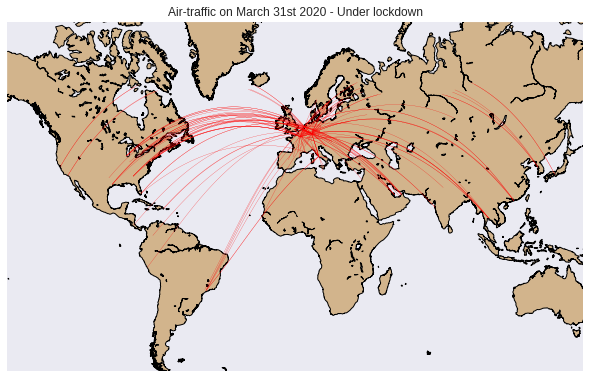

In [44]:
# Create Base Map
m = Basemap(projection = "merc",
            llcrnrlat=-55,urcrnrlat=75,llcrnrlon=-150,urcrnrlon=150
            ,rsphere=(6378137.00,6356752.3142)
            ,resolution='l'
            )

fig = plt.figure(figsize=(10,12))
ax=fig.add_axes([0.1,0.1,0.8,0.8])
for i in range(df_mar31st.shape[0]):
  m.drawgreatcircle(df_mar31st.iloc[i]['longitude_orig'],
                    df_mar31st.iloc[i]['latitude_orig'],
                    df_mar31st.iloc[i]['longitude_dest'],
                    df_mar31st.iloc[i]['latitude_dest'],
                    linewidth=.2,color='r')
m.drawcoastlines()
m.fillcontinents(color='tan')
ax.set_title('Air-traffic on March 31st 2020 - Under lockdown')
plt.show()

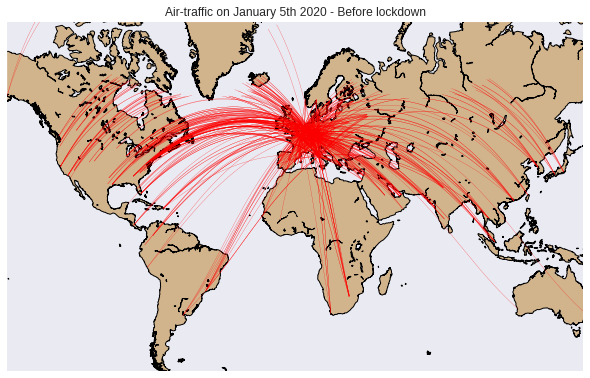

In [45]:
# Create Base Map
m = Basemap(projection = "merc",
            llcrnrlat=-55,urcrnrlat=75,llcrnrlon=-150,urcrnrlon=150
            ,rsphere=(6378137.00,6356752.3142)
            ,resolution='l'
            )

fig = plt.figure(figsize=(10,12))
ax=fig.add_axes([0.1,0.1,0.8,0.8])
for i in range(df_jan5th.shape[0]):
  m.drawgreatcircle(df_jan5th.iloc[i]['longitude_orig'],
                    df_jan5th.iloc[i]['latitude_orig'],
                    df_jan5th.iloc[i]['longitude_dest'],
                    df_jan5th.iloc[i]['latitude_dest'],
                    linewidth=.2,color='r')
m.drawcoastlines()
m.fillcontinents(color='tan')
ax.set_title('Air-traffic on January 5th 2020 - Before lockdown')
plt.show()